In [6]:
from collections import defaultdict
import math

import numpy as np
import cupy as cp
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [7]:
RNG = np.random.default_rng()

if cp.cuda.is_available():
# if cp.cuda.is_available() and False:
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
print(f'xp = {xp.__name__}')

xp = numpy


In [27]:
# sbv_dims = [1000]
# non_zero_bits_list = range(1, 10)
# sbv_dims = [1000, 1200, 1500, 1800, 2000, 2500, 3000, 3500, 4000, 5000]
sbv_dims = [256]
# sbv_dims = [256, 512]
# sbv_dims = [256, 512, 1024]
# sbv_dims = [1200, 1300, 1400, 1500]
# sbv_dims = [1000]
# non_zero_bits_list = range(2, 26)
# non_zero_bits_list = range(2, 31)
# non_zero_bits_list = range(2, 3)
non_zero_bits_list = range(8, 9)
index = []
columns = defaultdict(list)
# min_entities_count = 128 ** 2 # ~16k 
# min_entities_count = 32 ** 2 # ~1k
# min_entities_count = 100
# min_entities_count = 9 * 4 * 50 * 2 # 10 degree, 3600
# min_entities_count = 6 * 4 * 50 * 2 # 15 degree, 2400
# min_entities_count = 5 * 4 * 50 * 2 # 18 degree, 2000
# min_entities_count = 3 * 4 * 50 * 2 # 30 degree, 1200
# min_entities_count = 36 * 128 * 128
# min_entities_count = 128 * 10 + 128 * 10 + 36 * 10
# min_entities_count = 1000 * 24 # 15 degree fidelity
# min_entities_count = 1000
min_entities_count = 260

for sbv_dim in tqdm(sbv_dims, desc='sbv_dim'):
    index.append((min_entities_count, sbv_dim, 'bundle_size_0_FP'))
    index.append((min_entities_count, sbv_dim, 'bundle_size_1_FP'))
    index.append((min_entities_count, sbv_dim, 'bundle_size_2_FP'))
    index.append((min_entities_count, sbv_dim, 'bundle_ones_count_0_FP'))
    index.append((min_entities_count, sbv_dim, 'bundle_ones_count_1_FP'))
    index.append((min_entities_count, sbv_dim, 'bundle_ones_count_2_FP'))

    for non_zero_bits in tqdm(non_zero_bits_list, leave=False, desc='non_zero_bits'):
        bundle_size_0_FP = 0
        bundle_size_1_FP = 0
        bundle_size_2_FP = 0
        bundle_size_to_max_ones_count = {}
        entities_count = math.comb(sbv_dim, non_zero_bits)

        if entities_count >= min_entities_count:
            entities = np.zeros((min_entities_count, sbv_dim), dtype='f')
            unique_entity_codes = set()
            
            for i in tqdm(range(entities.shape[0]), leave=False, desc='entities'):
                attempts_to_get_unique_entity_code = 10

                for _ in range(attempts_to_get_unique_entity_code):
                    ii = RNG.choice(sbv_dim, non_zero_bits, replace=False)
                    entity_code = tuple(sorted(ii))

                    if not entity_code in unique_entity_codes:
                        entities[i][ii] = 1
                        unique_entity_codes.add(entity_code)
                        break
                else:
                    assert False, f'Failed to get unique entity code within {attempts_to_get_unique_entity_code} attempts'

            assert np.all(entities.sum(axis=1) == non_zero_bits)
            entities = xp_array_to_gpu(entities)

            for bundle_size in tqdm(list(range(1, 101)), leave=False, desc='bundle_size'):
                errors_count_list = []
                max_ones_count = 0
                
                for _ in range(50):
                    # entity_inds = RNG.choice(entities.shape[0], bundle_size, replace=False)
                    # entities_for_bundle = entities[entity_inds]
                    # sbv = xp.where(entities_for_bundle.sum(axis=0) > 0, 1, 0)
                    # entities_for_bundle_restored = entities[((entities @ sbv) == non_zero_bits)]
                    # errors_count = xp.count_nonzero(entities_for_bundle.sum(axis=0) != entities_for_bundle_restored.sum(axis=0))

                    entity_inds = RNG.choice(entities.shape[0], bundle_size, replace=False)
                    entity_inds_mask = xp.zeros(entities.shape[0], dtype=bool)
                    entity_inds_mask[entity_inds] = True
                    entities_for_bundle = entities[entity_inds]
                    sbv = xp.where(entities_for_bundle.sum(axis=0) > 0, 1, 0)
                    # entity_inds_mask_restored = (entities @ sbv) == non_zero_bits
                    entity_inds_mask_restored = (entities @ sbv) >= 4
                    assert xp.all((entity_inds_mask_restored * entity_inds_mask) == entity_inds_mask) # assert than we don't lose any entities during restore procedure
                    errors_count = int((entity_inds_mask != entity_inds_mask_restored).sum()) # count False positives (phantom entities)
                    errors_count_list.append(errors_count)
                    max_ones_count = max(max_ones_count, sbv.sum())

                bundle_size_to_max_ones_count[bundle_size] = max_ones_count
                errors_count_list = np.array(errors_count_list)
                min_errors_count = np.min(errors_count_list)
                        
                if min_errors_count > 2:
                    break

                bundle_size_0_FP = bundle_size if np.all(errors_count_list <= 0) and bundle_size_0_FP == bundle_size - 1 else bundle_size_0_FP
                bundle_size_1_FP = bundle_size if np.all(errors_count_list <= 1) and bundle_size_1_FP == bundle_size - 1 else bundle_size_1_FP
                bundle_size_2_FP = bundle_size if np.all(errors_count_list <= 2) and bundle_size_2_FP == bundle_size - 1 else bundle_size_2_FP

        columns[non_zero_bits].append(bundle_size_0_FP)        
        columns[non_zero_bits].append(bundle_size_1_FP)        
        columns[non_zero_bits].append(bundle_size_2_FP)        
        columns[non_zero_bits].append(bundle_size_to_max_ones_count[bundle_size_0_FP])
        columns[non_zero_bits].append(bundle_size_to_max_ones_count[bundle_size_1_FP])
        columns[non_zero_bits].append(bundle_size_to_max_ones_count[bundle_size_2_FP])
        
        # columns[non_zero_bits].append(bundle_size_0_FP * non_zero_bits)
        # columns[non_zero_bits].append(bundle_size_1_FP * non_zero_bits)
        # columns[non_zero_bits].append(bundle_size_2_FP * non_zero_bits)

sbv_dim:   0%|          | 0/1 [00:00<?, ?it/s]

non_zero_bits:   0%|          | 0/1 [00:00<?, ?it/s]

entities:   0%|          | 0/260 [00:00<?, ?it/s]

bundle_size:   0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
pd.DataFrame(columns, index=pd.MultiIndex.from_tuples(index, names=['entities', 'N', 'param']))

8
entities N   param                     
260      256 bundle_size_0_FP         1
             bundle_size_1_FP         2
             bundle_size_2_FP         2
             bundle_ones_count_0_FP   8
             bundle_ones_count_1_FP  16
             bundle_ones_count_2_FP  16

In [24]:
crossings = entities @ entities.T
crossings[xp.diag_indices_from(crossings)] = 0
np.flatnonzero(np.any(crossings >= 4, axis=1))

array([], dtype=int64)

In [431]:
# sbv_dims = [256]
# sbv_dims = [1000]
sbv_dims = [512]
non_zero_bits_list = range(8, 9)
# min_entities_count = 260
min_entities_count = 1000
columns = defaultdict(list)

for sbv_dim in tqdm(sbv_dims, desc='sbv_dim'):
    for non_zero_bits in tqdm(non_zero_bits_list, leave=False, desc='non_zero_bits'):
        entities_count = math.comb(sbv_dim, non_zero_bits)

        if entities_count >= min_entities_count:
            entities = np.zeros((min_entities_count, sbv_dim), dtype='f')
            unique_entity_codes = set()
            
            for i in tqdm(range(entities.shape[0]), leave=False, desc='entities'):
                attempts_to_get_unique_entity_code = 10

                for _ in range(attempts_to_get_unique_entity_code):
                    ii = RNG.choice(sbv_dim, non_zero_bits, replace=False)
                    entity_code = tuple(sorted(ii))
                    entity_code = tuple(sorted(ii))

                    if not entity_code in unique_entity_codes:
                        entities[i][ii] = 1
                        unique_entity_codes.add(entity_code)
                        break
                else:
                    assert False, f'Failed to get unique entity code within {attempts_to_get_unique_entity_code} attempts'

            assert np.all(entities.sum(axis=1) == non_zero_bits)
            entities = xp_array_to_gpu(entities)

            for bundle_size in tqdm(list(range(10, 21)), leave=False, desc='bundle_size'):
                for thres in range(non_zero_bits // 2, non_zero_bits + 1):
                    for trial_no in range(100):
                        entity_inds = RNG.choice(entities.shape[0], bundle_size, replace=False)
                        entity_inds_mask = xp.zeros(entities.shape[0], dtype=bool)
                        entity_inds_mask[entity_inds] = True
                        entities_for_bundle = entities[entity_inds]
                        sbv = xp.where(entities_for_bundle.sum(axis=0) > 0, 1, 0)
                        entity_inds_mask_restored = (entities @ sbv) >= thres
                        assert xp.all((entity_inds_mask_restored * entity_inds_mask) == entity_inds_mask) # assert than we don't lose any entities during restore procedure
                        false_positives_count = int((entity_inds_mask != entity_inds_mask_restored).sum())

                        columns['sbv_dim'].append(sbv_dim)
                        columns['entites_count'].append(entities.shape[0])
                        columns['nzb_count'].append(non_zero_bits)
                        columns['bundle_size'].append(bundle_size)
                        columns['thres'].append(thres)
                        columns['trial_no'].append(trial_no)
                        columns['fps_count'].append(false_positives_count)

df = pd.DataFrame(columns)
df_pivot = pd.pivot_table(
    df, 
    index=['sbv_dim', 'nzb_count', 'entites_count', 'bundle_size', 'thres'],
    columns='fps_count',
    values=['trial_no'], 
    aggfunc=dict(trial_no='count'))

for column in df_pivot.columns:
    df_pivot[column] = df_pivot[column].map(lambda x: f'{x:.0f}').replace('nan', '')

df_pivot

sbv_dim:   0%|          | 0/1 [00:00<?, ?it/s]

non_zero_bits:   0%|          | 0/1 [00:00<?, ?it/s]

entities:   0%|          | 0/1000 [00:00<?, ?it/s]

bundle_size:   0%|          | 0/11 [00:00<?, ?it/s]

trial_no                  \
fps_count                                              0   1   2   3   4     
sbv_dim nzb_count entites_count bundle_size thres                            
512     8         1000          10          4                                
                                            5            8  22  23  16  22   
                                            6           89  11               
                                            7          100                   
                                            8          100                   
                                11          4                                
                                            5            5  20  15  21  16   
                                            6           75  24   1           
                                            7           98   2               
                                            8          100                   
                                12          4                                
                                            5                4  11  13   8   
                                            6           58  31  10   1       
                                            7           97   3               
                                            8          100                   
                                13          4                                
                                            5                2   1   5   9   
                                            6           46  39   7   4   2   
                                            7           95   5               
                                            8          100                   
                                14          4                                
                                            5                    1   1   6   
                                            6           38  34  21   6   1   
                                            7           91   9               
                                            8          100                   
                                15          4                                
                                            5                        1   1   
                                            6           26  40  23   8   2   
                                            7           92   8               
                                            8           99   1               
                                16          4                                
                                            5                                
                                            6           15  35  22  13   6   
                                            7           82  15   2   1       
                                            8           99   1               
                                17          4                                
                                            5                                
                                            6            6  13  24  30  12   
                                            7           85  11   3   1       
                                            8           99   1               
                                18          4                                
                                            5                                
                                            6            2   9  23  16  16   
                                            7           70  26   4           
                                            8           98   2               
                                19          4                                
                                            5                                
                                            6            1   5  14  15  18   
                                            7           66  26   7   1  

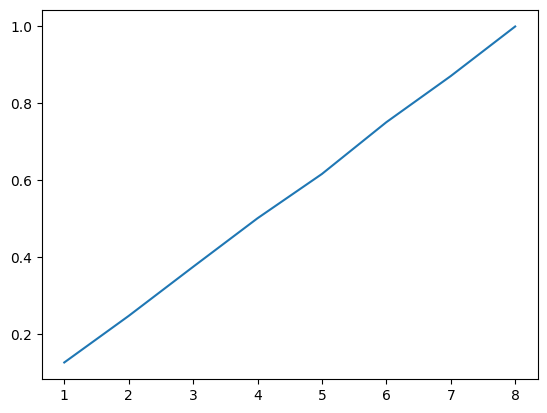

In [302]:
hi = 8
trials_count = 10_000
variants = set(range(hi))
xxyy = []

for attempts_count in range(1, 9):
    successes_count = 0
    
    for trial_no in range(trials_count):
        secret = RNG.choice(hi)
        tried = set()
    
        for attempt_no in range(attempts_count):
            guess = RNG.choice(list(variants - tried))
    
            if guess == secret:
                successes_count += 1
                break
            
            assert not guess in tried
            tried.add(guess)

    xxyy.append([attempts_count, successes_count / trials_count])
    # successes_count, successes_count / trials_count

xxyy = np.array(xxyy)
plt.plot(xxyy[:,0], xxyy[:,1]);

In [343]:
dims_count = 10
nzb_count = 3
trials_count = 10_000
variants = set(range(hi))
attempts_count = 5
successes_count = 0

for trial_no in range(trials_count):
    secrets = set(RNG.choice(dims_count, (nzb_count,), replace=False))
    assert len(secrets) == nzb_count
    guessed = set()
    tried = set()

    for attempt_no in range(attempts_count):
        guess = RNG.choice(list(variants - tried))

        if guess in secrets:
            assert not guess in guessed
            guessed.add(guess)
        
        assert not guess in tried
        tried.add(guess)

    if guessed == secrets:
        successes_count += 1
    
successes_count, successes_count / trials_count

(837, 0.0837)

# Расчёт необходимого кол-ва комбинаторных точек для заданной схемы кодирования

In [494]:
DIMS_COUNT = 512
ENTITY_NZB_COUNT = 8
ENTITY_MIN_NZB_COUNT = 4
assert ENTITY_MIN_NZB_COUNT <= ENTITY_NZB_COUNT
POINT_NZB_COUNT = 40
POINTS_COUNT = 640

## Аналитическое решение

In [471]:
max_wrong_picks_count = ENTITY_NZB_COUNT - ENTITY_MIN_NZB_COUNT
chance_nomin_part1 = math.prod(range(POINT_NZB_COUNT, POINT_NZB_COUNT - ENTITY_MIN_NZB_COUNT, -1))
chances = []

for wrong_picks_count in range(max_wrong_picks_count + 1):
    # compute solo chance of getting a single correct guess by using number of wrong_picks
    l = 512 - POINT_NZB_COUNT
    chance_nomin_part2 = math.prod(range(l, l - wrong_picks_count, -1))
    chance_denom = math.prod(range(DIMS_COUNT, DIMS_COUNT - ENTITY_MIN_NZB_COUNT - wrong_picks_count, -1))
    chance = chance_nomin_part1 * chance_nomin_part2 / chance_denom
    
    # but we have a bunch of ways to make correct guess by using number of wrong_picks, need to compute number of such ways
    ways_of_correct_guess = math.comb(ENTITY_MIN_NZB_COUNT + wrong_picks_count, ENTITY_MIN_NZB_COUNT)

    if wrong_picks_count > 0:
        ways_of_correct_guess -= math.comb(ENTITY_MIN_NZB_COUNT + wrong_picks_count - 1, wrong_picks_count - 1)       

    # now compute chance of getting correct ways in all possible ways
    chance = ways_of_correct_guess * chance
    chances.append(chance)   

sum(chances)

0.0017905447675959911

In [478]:
p = sum(chances)
chance_to_by_many_points = sum(map(lambda i: p * (1 - p) ** i, range(POINTS_COUNT)))
chance_to_by_many_points

0.9026842684203584

## Эмпирическое решение

In [495]:
points = np.zeros((POINTS_COUNT, DIMS_COUNT), dtype='f')
unique_points = set()

while len(unique_points) < points.shape[0]:
    nzb = RNG.choice(points.shape[1], POINT_NZB_COUNT, replace=False)
    key = tuple(map(int, sorted(nzb)))

    if not key in unique_points:
        points[len(unique_points),nzb] = 1
        unique_points.add(key)

assert np.all(points.sum(axis=1) == POINT_NZB_COUNT)
points.shape

(640, 512)

In [496]:
crossings = points @ points.T
crossings[np.diag_indices(points.shape[0])] = 0
np.count_nonzero(np.any(crossings >= 32, axis=1))

0

In [497]:
def calc_ratio_of_clusters_covered_by_points(cluster_size, cluster_nzb_count, cluster_enough_nzb_count):
    assert cluster_enough_nzb_count <= cluster_nzb_count
    l = 100_000
    clusters = []
    
    for _ in range(l):
        nzb = RNG.choice(cluster_size, cluster_nzb_count, replace=False)
        cluster = np.zeros(cluster_size, dtype='f')
        cluster[nzb] = 1
        clusters.append(cluster)

    clusters = np.array(clusters)
    r = np.any(clusters @ points.T >= cluster_enough_nzb_count, axis=1)
    return np.count_nonzero(r), np.count_nonzero(r) / clusters.shape[0]

In [498]:
%%time
calc_ratio_of_clusters_covered_by_points(DIMS_COUNT, ENTITY_NZB_COUNT, ENTITY_MIN_NZB_COUNT)

CPU times: user 6.33 s, sys: 4.68 s, total: 11 s
Wall time: 1.68 s


(68103, 0.68103)